# Testing Tenor MFCC with Convolutional Neural Network

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

from keras.metrics import AUC, Recall
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from _common import NUM_LABEL_COLS, RANDOM_SEED
from _tenor_mfcc import TEST_SIZE, VALIDATION_SIZE, \
    BANDS, TIME_SLICES, df_filtered, mfccs, data, target
# Note that records are read from pickle, selected, filtered,
# and scaled with `sklearn.preprocessing.StandardScaler` 
# in `_tenor_mfcc.py`.

In [2]:
mfccs.head()

,mfcc_0_0,mfcc_0_1,mfcc_0_2,mfcc_0_3,mfcc_0_4,mfcc_0_5,mfcc_0_6,mfcc_0_7,mfcc_0_8,mfcc_0_9,...,mfcc_19_421,mfcc_19_422,mfcc_19_423,mfcc_19_424,mfcc_19_425,mfcc_19_426,mfcc_19_427,mfcc_19_428,mfcc_19_429,mfcc_19_430
0,-262.535278,-264.593231,-264.253876,-258.306427,-180.095154,-104.992142,-74.136917,-74.703041,-76.241982,-70.617165,...,0.527700,-2.907736,-2.693354,-1.315093,1.446734,3.277715,4.708402,1.324104,-0.128786,3.472323
1,-143.286331,-154.023926,-165.027695,-171.412842,-174.109100,-180.226807,-184.423111,-184.438721,-183.394211,-184.598022,...,-11.491327,-11.704226,-10.279772,-4.682507,-7.300425,-9.988886,-8.354725,-9.616585,-8.910596,-11.309555
2,-206.313293,-211.238693,-214.663116,-219.083893,-227.416504,-229.910263,-225.391541,-237.068161,-211.324493,-190.541931,...,-1.053334,-4.555957,-1.551906,2.897170,-2.583026,-8.363262,-7.673847,-4.877136,-9.546298,-11.487730
5,-199.009140,-203.184052,-215.817017,-223.724991,-210.204926,-208.025604,-216.702896,-221.232498,-223.262833,-235.327850,...,11.713816,12.476087,15.275761,16.053020,14.997152,7.687865,4.876099,10.443269,13.605841,10.477378
13,-178.072861,-180.171799,-190.439331,-194.704590,-174.116180,-147.635284,-147.692657,-148.911469,-157.480698,-163.331482,...,-5.211812,-0.377501,-3.095351,-6.423543,-6.744158,-2.290309,2.799366,3.882173,3.381578,10.294922


In [9]:
# ^ these are the labels
print(data.shape)  # We should have 8620 = 431 x 20 columns
print(target.shape)

(5827, 8620)
(5827,)


In [10]:
x_train, x_test, y_train, y_test = \
     train_test_split(data, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

In [15]:
x_train = x_train.reshape(x_train.shape[0], BANDS, TIME_SLICES, 1)
x_test = x_test.reshape(x_test.shape[0], BANDS, TIME_SLICES, 1)

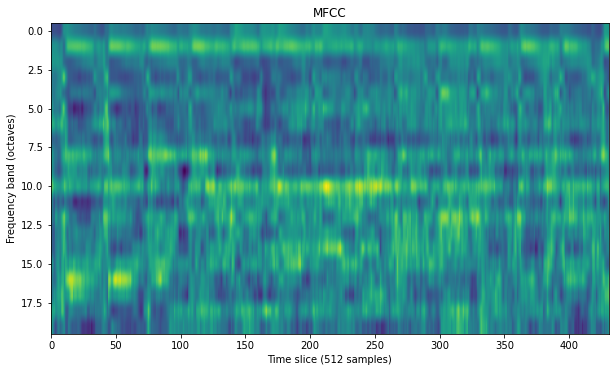

In [51]:
# Just take a little peek at our data
plt.figure(figsize=(10, 10))
plt.xlabel("Time slice (512 samples)")
plt.ylabel("Frequency band (octaves)")
plt.title("MFCC")
plt.imshow(x_train[10, :, :, 0], aspect=12.0)  # First number in the list is the nth training sample
pass

In [48]:
NUM_EPOCHS = 4
BATCH_SIZE = 32
INPUT_SHAPE = (20, 431, 1)

# https://www.tensorflow.org/tutorials/images/cnn
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
# https://keras.io/api/layers/reshaping_layers/flatten/
# https://keras.io/api/layers/core_layers/dense/
# Architecture based in part on 
#   https://www.kaggle.com/ashirahama/simple-keras-cnn-with-mfcc
model = Sequential()
# Conv2D (from the docs)
# 2D convolution layer (e.g. spatial convolution over images).
# This layer creates a convolution kernel that is convolved with 
# the layer input to produce a tensor of outputs. 
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
# MaxPooling2D (from the docs)
# "Downsamples the input representation by taking the maximum value over the 
# window defined by pool_size for each dimension along the features axis. 
# The window is shifted by strides in each dimension. The resulting output 
# when using "valid" padding option has a shape (number of rows or columns) 
# of: output_shape = (input_shape - pool_size + 1) / strides)""
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())  # Flattens the input. Does not affect the batch size.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall')])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)
loss, recall = model.evaluate(x_test, y_test)


Train on 3728 samples, validate on 933 samples
Epoch 1/4
3728/3728 [==============================] - 202s 54ms/step - loss: 0.5871 - recall: 0.7257 - val_loss: 0.4221 - val_recall: 0.9194
Epoch 2/4
3728/3728 [==============================] - 199s 53ms/step - loss: 0.3889 - recall: 0.8293 - val_loss: 0.3485 - val_recall: 0.8781
Epoch 3/4
3728/3728 [==============================] - 205s 55ms/step - loss: 0.3243 - recall: 0.8584 - val_loss: 0.3373 - val_recall: 0.8223
Epoch 4/4
1166/1166 [==============================] - 9s 8ms/step


In [49]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

1166/1166 [==============================] - 8s 7ms/step
Recall: 86.54


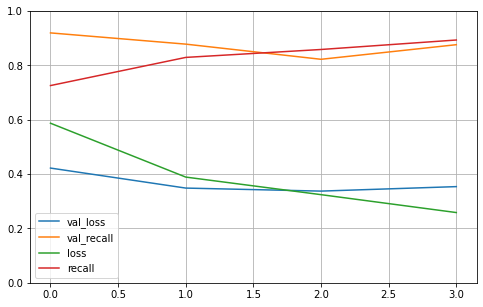

In [50]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [52]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(48, kernel_size=(5, 5), activation='relu'))
model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall')])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)
loss, recall = model.evaluate(x_test, y_test)


Train on 3728 samples, validate on 933 samples
Epoch 1/4
3728/3728 [==============================] - 236s 63ms/step - loss: 0.6271 - recall: 0.6502 - val_loss: 0.4416 - val_recall: 0.8740
Epoch 2/4
3728/3728 [==============================] - 253s 68ms/step - loss: 0.4724 - recall: 0.7985 - val_loss: 0.4037 - val_recall: 0.7748
Epoch 3/4
3728/3728 [==============================] - 228s 61ms/step - loss: 0.4009 - recall: 0.8386 - val_loss: 0.3973 - val_recall: 0.8368
Epoch 4/4
1166/1166 [==============================] - 16s 13ms/step


In [53]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

1166/1166 [==============================] - 16s 14ms/step
Recall: 86.89


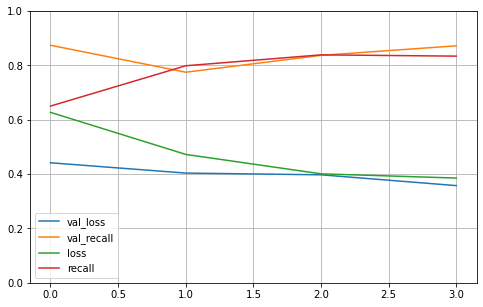

In [54]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [61]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(56, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(108, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall')])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)
loss, recall = model.evaluate(x_test, y_test)


Train on 3728 samples, validate on 933 samples
Epoch 1/4
3728/3728 [==============================] - 182s 49ms/step - loss: 0.5769 - recall: 0.6705 - val_loss: 0.3796 - val_recall: 0.8161
Epoch 2/4
3728/3728 [==============================] - 164s 44ms/step - loss: 0.3863 - recall: 0.8522 - val_loss: 0.3924 - val_recall: 0.9360
Epoch 3/4
3728/3728 [==============================] - 179s 48ms/step - loss: 0.3025 - recall: 0.8870 - val_loss: 0.3335 - val_recall: 0.8636
Epoch 4/4
1166/1166 [==============================] - 10s 9ms/step


In [60]:
size = 32
kernel_size = 5
padding = 0
stride = 1
((size - kernel_size + 2 * padding) / stride) + 1

size = 56
kernel_size = 3
((size - kernel_size + 2 * padding) / stride) + 1

54.0

In [62]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

1166/1166 [==============================] - 10s 9ms/step
Recall: 88.81


In [63]:
# Conv2D/64/K3,3/ReLU/input_shape
# Conv2D/48/K5,5/ReLU
# Conv2D/128/K5,5/ReLU
# MaxPooling2D/P5,5
# Dropout/0.25
# Flatten
# Dense/64/ReLU
# Dropout/0.25
# Dense/64/ReLU
# Dropout/0.4
# Dense/1/sigmoid
# 
# 4 epochs -> 76.22 recall

# Conv2D/32/K5,5/ReLU/input_shape
# Conv2D/56/K3,3/ReLU
# Conv2D/108/K3,3/ReLU
# MaxPooling2D/P2,2
# Dropout/0.25
# Flatten
# Dense/64/ReLU
# Dropout/0.25
# Dense/128/ReLU  << Increasing this
# Dropout/0.25    << and decreasing this resulted in 10% reduction in recall
# Dense/1/sigmoid
# 
# 4 epochs -> 79.02 recall

In [66]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu',
                 input_shape=INPUT_SHAPE))
model.add(Conv2D(56, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(108, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall')])
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)
loss, recall = model.evaluate(x_test, y_test)


Train on 3728 samples, validate on 933 samples
Epoch 1/4
3728/3728 [==============================] - 213s 57ms/step - loss: 0.5652 - recall: 0.7356 - val_loss: 0.3819 - val_recall: 0.7996
Epoch 2/4
3728/3728 [==============================] - 204s 55ms/step - loss: 0.4359 - recall: 0.8240 - val_loss: 0.3834 - val_recall: 0.8244
Epoch 3/4
3728/3728 [==============================] - 183s 49ms/step - loss: 0.3504 - recall: 0.8647 - val_loss: 0.3478 - val_recall: 0.8079
Epoch 4/4
1166/1166 [==============================] - 20s 17ms/step


In [67]:
# auc, 
loss, recall = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))

1166/1166 [==============================] - 14s 12ms/step
Recall: 87.41
